In [1]:
%reset -sf
import numpy as np
import matplotlib.pyplot as plt
import linecache
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle

In [2]:
# initialize mode params
num_mode=3
ny=161
nz=23
y=np.zeros((ny,1))
z=np.zeros((nz,1))
data1=np.zeros((ny,nz))
data2=np.zeros((ny,nz))
mode_data=[['' for i in range(3)] for j in range(1)]

In [3]:
# get mode1-3 E and H data
j=0
for i in range(3+1,3+1+ny):
    y[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode1_ey.txt', i).split()
    j+=1

j=0
for i in range(3+ny+2+1,3+ny+2+1+nz):
    z[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode1_ey.txt', i).split()
    j+=1

for k in range(num_mode):
    j=0
    for i in range(3+ny+2+nz+2+1,3+ny+2+nz+2+1+ny):
        data1[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode'+str(k+1)+'_ey.txt', i).split()
        j+=1  
    mode_data[0][k]=np.copy(data1.T)

# Normlize integral{|E|^2*dydz} to 1
dy=(y[-1,0]-y[0,0])/(y.shape[0]-1)
dz=(z[-1,0]-z[0,0])/(z.shape[0]-1)
norm_mode=np.zeros((1,num_mode))
for i in range(num_mode):
    norm_mode[0,i]=np.sum(mode_data[0][i]**2*dy*dz)
    mode_data[0][i]/=np.sqrt(norm_mode[0,i])

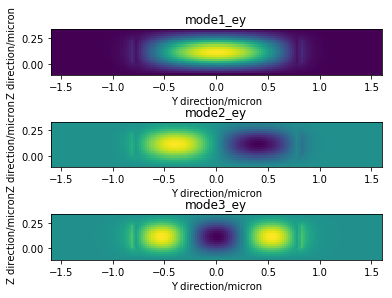

In [4]:
# show three Ey modes
# generate 2d grids for y and z
yy,zz=np.meshgrid(y,z)
plt.figure()
for i in range(num_mode):
    plt.subplot(num_mode, 1, i+1)
    plt.title('mode{}_ey'.format(i+1))
    plt.pcolormesh(yy,zz,mode_data[0][i])
    plt.xlabel("Y direction/micron")
    plt.ylabel("Z direction/micron")
    plt.ylim(-0.11, 0.33)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [5]:
# Synthesis data set
m_base=300
if True:
    m_all=m_base # number of all the samples

    # pert=0.05 # perturbation of intensity after field's superposition

    np.random.seed(0) # random seed(0)
    rd1=np.random.rand(3,m_base)
    np.random.seed(1) # random seed(1)
    rd2=np.random.rand(3,m_base)

    mode_comp=np.zeros((num_mode,m_all),dtype=complex)
    mode_comp[:,:m_base]=rd1*np.exp(1j*rd2*2*np.pi)

    field_sp=[[0+1j for i in range(m_all)] for j in range(1)] # [[Ey(0),...,Ey(m_all-1)]]
    for i in range(m_all):
        for j in range(num_mode):
            field_sp[0][i]+=mode_comp[j,i]*mode_data[0][j]
    mode_comp_label=np.abs(field_sp)**2/np.sum(np.abs(field_sp)**2,axis=0)
    
else:
    with open('training_data_add_1_102417.data', 'rb') as f:
        training_data_add_1 = pickle.load(f)
    with open('training_data_add_2_102417.data', 'rb') as f:
        training_data_add_2 = pickle.load(f)

    m_all=m_base+len(training_data_add_1)+len(training_data_add_2) # number of all the samples

    # pert=0.05 # perturbation of intensity after field's superposition

    np.random.seed(0) # random seed(0)
    rd1=np.random.rand(3,m_base)
    np.random.seed(1) # random seed(1)
    rd2=np.random.rand(3,m_base)

    mode_comp=np.zeros((num_mode,m_all),dtype=complex)
    mode_comp[:,:m_base]=rd1*np.exp(1j*rd2*2*np.pi)
    mode_comp[:,m_base:m_base+len(training_data_add_1)]=np.array(training_data_add_1).T
    mode_comp[:,m_base+len(training_data_add_1):m_base+len(training_data_add_1)+len(training_data_add_2)]=\
                                                                                    np.array(training_data_add_2).T

    # mode_comp_label=rd1**2/np.sum(rd1**2,axis=0)

    field_sp=[[0+1j for i in range(m_all)] for j in range(1)] # [[Ey(0),...,Ey(m_all-1)]]
    for i in range(m_all):
        for j in range(num_mode):
            field_sp[0][i]+=mode_comp[j,i]*mode_data[0][j]
    mode_comp_label=np.abs(field_sp)**2/np.sum(np.abs(field_sp)**2,axis=0)

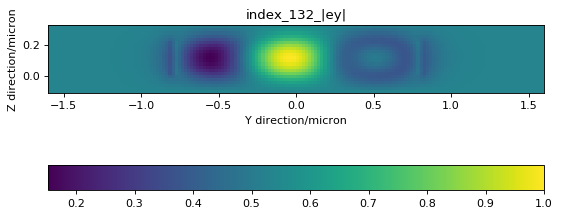

In [17]:
# view specified sample
index=132
plt.figure(num=None, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
plt.title('index_{}_|ey|'.format(index))
plt.pcolormesh(yy,zz,np.abs(field_sp[0][index])/np.max(np.abs(field_sp[0][index])))
plt.xlabel("Y direction/micron")
plt.ylabel("Z direction/micron")
plt.ylim(-0.11, 0.33)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(orientation='horizontal')
plt.show()

In [7]:
# get farfield diffraction pattern
sp_y=y.shape[0] # sampling points along y
sp_z=z.shape[0] # sampling points along z
ff_data=[]
for i in range(m_all):
    ff_data.append(np.fft.fftshift(np.fft.fft2(field_sp[0][i]))/sp_y/sp_z)

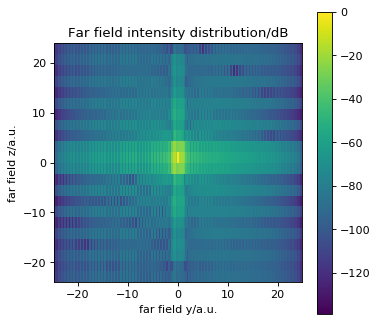

In [18]:
# view specified farfield pattern
sl_y=dy # sampling length(unit) along y
sl_z=dz # sampling length(unit) along z
sf_y=1/dy # sampling frequency along y
sf_z=1/dz # sampling frequency along z
f_y=np.fft.fftshift(np.fft.fftfreq(sp_y,sl_y))
f_z=np.fft.fftshift(np.fft.fftfreq(sp_z,sl_z))
index=132
plt.figure(num=None, figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
plt.pcolormesh(f_y,f_z,20*np.log10(np.abs(ff_data[index])/np.max(np.abs(ff_data[index]))))
plt.title('Far field intensity distribution/dB')
plt.xlabel('far field y/a.u.')
plt.ylabel('far field z/a.u.')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [11]:
ff_i_data_x=['' for i in range(m_all)]
for i in range(m_all):
    ff_i_data_x[i]=np.sum(np.abs(ff_data[i])**2,axis=0,keepdims=True)

In [19]:
np.log10(ff_i_data_x[index]).shape

(1, 161)

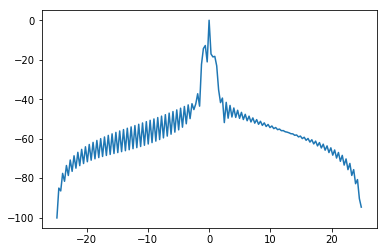

In [20]:
plt.plot(f_y,np.squeeze(10*np.log10(ff_i_data_x[index]/np.max(ff_i_data_x[index]))))
plt.show()

In [16]:
np.nonzero(10*np.log10(ff_i_data_x[154]/np.max(ff_i_data_x[154]))>=-30)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84], dtype=int64))

In [ ]:
ff_i_data_x=np.array(ff_i_data_x).squeeze().T
ff_i_data_x=ff_i_data_x[71:90,:]
ff_i_data_x.shape

In [ ]:
X=np.array(range(10))
Y=np.array(range(10))
permutation = list(np.random.permutation(10))
shuffled_X = X[permutation]
shuffled_Y = Y[permutation]
print(shuffled_X,shuffled_Y)
# Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

In [ ]:
X_train=np.log10(ff_i_data_x[:,:200])
X_test=np.log10(ff_i_data_x[:,200:300])
Y_train=mode_comp_label[:,:200]
Y_test=mode_comp_label[:,200:300]

In [ ]:
font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 15}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 15}

plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(list(range(19)),X_train[:,119],'o-')
plt.title('Logarithmic farfield intensity compressed to y axis', **font_suptitle,y=1.05)
plt.xlabel('Feature index (y axis)', **font_label)
plt.ylabel('Logarithmic intensity', **font_label)
plt.xticks(list(range(19)),[str(i) for i in range(1,20)],**font_tick)
plt.yticks(**font_tick)
plt.show()

In [ ]:
# data analysis
X_train_vars=np.var((X_train),axis=1)
plt.plot(range(X_train.shape[0]),X_train_vars)
plt.show()

In [ ]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32,[n_x,None])
    Y = tf.placeholder(tf.float32,[n_y,None])
    return X, Y

In [ ]:
def initialize_parameters(parameters=None):
    if parameters==None:
        tf.set_random_seed(2)      
        W1 = tf.get_variable("W1", [25,19], initializer = tf.contrib.layers.xavier_initializer(seed = 3))
        b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
        W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 4))
        b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
        W3 = tf.get_variable("W3", [3,12], initializer = tf.contrib.layers.xavier_initializer(seed = 5))
        b3 = tf.get_variable("b3", [3,1], initializer = tf.zeros_initializer())
    else:
        W1 = tf.get_variable("W1",  initializer = tf.constant(parameters['W1']))
        b1 = tf.get_variable("b1",  initializer = tf.constant(parameters['b1']))
        W2 = tf.get_variable("W2",  initializer = tf.constant(parameters['W2']))
        b2 = tf.get_variable("b2",  initializer = tf.constant(parameters['b2']))
        W3 = tf.get_variable("W3",  initializer = tf.constant(parameters['W3']))
        b3 = tf.get_variable("b3",  initializer = tf.constant(parameters['b3']))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [ ]:
def forward_propagation(X, parameters):   
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.matmul(W1,X) + b1                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.tanh(Z1)                                              # A1 = tanh(Z1)
    Z2 = tf.matmul(W2,A1) + b2                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.tanh(Z2)                                              # A2 = tanh(Z2)
    Z3 = tf.matmul(W3,A2) + b3                                              # Z3 = np.dot(W3,Z2) + b3
   
    return Z3

In [ ]:
def compute_cost1(Z3, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    Z3 = tf.transpose(Z3)
    Y = tf.transpose(Y)
    A3 = tf.nn.softmax(Z3)
    cost = tf.reduce_mean(tf.reduce_sum(tf.abs(Y-A3),axis=1))
    
    return cost

In [ ]:
def compute_cost2(Z3, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    Z3 = tf.transpose(Z3)
    Y = tf.transpose(Y)
    A3 = tf.nn.softmax(Z3)
    cost = tf.reduce_mean(tf.reduce_sum((Y-A3)**2,axis=1))
    
    return tf.transpose(A3),cost

In [ ]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [ ]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, parameters=None, lambd=0.01, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    seed = 6                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(parameters)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    regularizer = tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2)+tf.nn.l2_loss(W3)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    # cost1 = compute_cost1(Z3, Y) # L1 norm
    _,cost2 = compute_cost2(Z3, Y) # L2 norm
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost2 + lambd * regularizer)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost2], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        print ("Train mean square error:", sess.run(cost2,feed_dict={X: X_train, Y: Y_train}))
        print ("Test mean square error:", sess.run(cost2,feed_dict={X: X_test, Y: Y_test}))
        
        return parameters

In [ ]:
def model_check(X_train, Y_train, X_test, Y_test, parameters = None, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(parameters)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    # cost1 = compute_cost1(Z3, Y) # L1 norm
    A3,cost2 = compute_cost2(Z3, Y) # L2 norm
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        [parameters, A3_train, cost2_train]=sess.run([parameters, A3, cost2], feed_dict={X: X_train, Y: Y_train})
        [A3_test,cost2_test]=sess.run([A3, cost2], feed_dict={X: X_test, Y: Y_test})
    if print_cost==True:
        print("Train mean square error: {:.2e}.".format(cost2_train))
        print("Test mean square error: {:.2e}.".format(cost2_test))
        
        
        return parameters,A3_train,cost2_train,A3_test,cost2_test

In [ ]:
f = open('parameters.data', 'rb')
parameters = pickle.load(f)
f.close()
parameters=model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0004,
          num_epochs = 5000, minibatch_size = 8, parameters=parameters, lambd=0.00012, print_cost = True)

In [ ]:
parameters_set=[['' for i in range(10)] for j in range(10)]
np.random.seed(None)
lr_set=10**np.random.uniform(-4,-3,10)
lambd_set=10**np.random.uniform(-5,-3.5,10)
for i in range(len(lr_set)):
    for j in range(len(lambd)):
        f = open('parameters.data', 'rb')
        parameters = pickle.load(f)
        f.close()
        print('learning rate_{}: {}'.format(i,lr_set[i]))
        print('lambd_{}: {}'.format(j,lambd_set[j]))
        parameters_set[i][j]=model(X_train, Y_train, X_test, Y_test, learning_rate = lr_set[i],
          num_epochs = 5000, minibatch_size = 8, parameters=parameters, lambd=lambd_set[j], print_cost = True)

In [ ]:
f = open('parameters_L2_lambd_1eminus4.data', 'wb')
pickle.dump(parameters, f)
f.close()

In [ ]:
f = open('parameters.data', 'rb')
parameters = pickle.load(f)
f.close()

In [ ]:
[parameters,A3_train,cost_train,A3_test,cost_test]=model_check(X_train, Y_train, X_test, Y_test, parameters = parameters, print_cost = True)

In [ ]:
np.random.seed(None)
index=np.squeeze(np.random.randint(100,size=(1,1)))
print("index_{}:".format(index))
print(A3_test.T[index,:])
print(Y_test.T[index,:])

In [ ]:
A3_train=[['' for j in range(10)] for i in range(10)]
cost_train=np.zeros((10,10))
A3_test=[['' for j in range(10)] for i in range(10)]    
cost_test=np.zeros((10,10))
for i in range(len(lr_set)):
    for j in range(len(lambd)):
        [_,A3_train[i][j],cost_train[i,j],A3_test[i][j],cost_test[i,j]]=model_check(X_train, Y_train, X_test, Y_test, parameters = parameters_set[i][j], print_cost = True)

In [ ]:
min_tc_index=np.unravel_index(np.argmin(cost_test), (10,10)) # min test cost index
print(min_tc_index)

In [ ]:
cost_test[min_tc_index]

In [ ]:
cost_train[min_tc_index]

In [ ]:
# save hyprams minimizing cost_test
f = open('parameters_min_cost_test.data', 'wb')
pickle.dump([parameters_set[min_tc_index[0]][min_tc_index[1]],lr_set[min_tc_index[0]],lambd_set[min_tc_index[1]]], f)
f.close()

In [ ]:
# save all the hyprams tuning set
f = open('hyprams_tuning.data', 'wb') # parameters_set, lr_set, lambd_set
pickle.dump([parameters_set,lr_set,lambd_set], f)
f.close()

In [ ]:
[parameters,A3_train,cost_train,A3_test,cost_test]=model_check(X_train, Y_train, X_test, Y_test, parameters = parameters_set[9][8], print_cost = True)